In [6]:
import os 
import numpy as np
import matplotlib.pylab as plt
from itertools import zip_longest
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import json
import collections
import phycv
from phycv import PST, PST_GPU,VEVID,VEVID_GPU
import matplotlib.image as mpimg
from PIL import Image
from io import BytesIO
import cv2
import tqdm
import torchvision.transforms as transforms
import copy
from PIL import Image



/var/folders/35/kt_zt5x5511_dk_41bwj22c80000gn/T/ipykernel_7252/1685109211.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Step 1 - PST Algorithm

In [7]:
#PST on given img_file
def process_image(img_file=None,output_path=None,S=0.3, W=15, sigma_LPF=0.15, thresh_min=0.05,thresh_max=0.9,morph_flag=1,img=None,show=True):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if img_file is None:
        original_image=copy.deepcopy(img)
    else:
        original_image = mpimg.imread(img_file)
    if output_path:
        if not os.path.exists(output_path):
            os.makedirs(output_path)

    # run PST GPU version
    pst_gpu = PST_GPU(device=device)
    #pst_gpu=PST()
    #pst_output_gpu_torch = pst_gpu.run(
    #    img_file,
    #    S,
    #    W,
    #    sigma_LPF,
    #    thresh_min,
    #    thresh_max,
    #    morph_flag,
    #)
    pst_gpu.load_img(img_array=transforms.ToTensor()(original_image))
    pst_gpu.init_kernel(S,W)
    pst_gpu.apply_kernel(sigma_LPF,thresh_min,thresh_max,morph_flag)
    pst_output_gpu_torch=pst_gpu.pst_output
    pst_output_gpu = pst_output_gpu_torch.cpu().numpy()
    pst_gpu_result = Image.fromarray((pst_output_gpu * 255).astype(np.uint8))
    if show:
        f, axes = plt.subplots(1, 2, figsize=(12, 8))
        axes[0].imshow(original_image)
        axes[0].axis("off")
        axes[0].set_title("Original Image")
        axes[1].imshow(pst_output_gpu, cmap="gray")
        axes[1].axis("off")
        axes[1].set_title("PhyCV Edge Detection")
        if output_path:
            plt.savefig(os.path.join(output_path, "PST_GPU_compare.jpg"), bbox_inches="tight")
            pst_gpu_result.save(os.path.join(output_path, "PST_GPU_output.jpg"))
    return pst_gpu_result

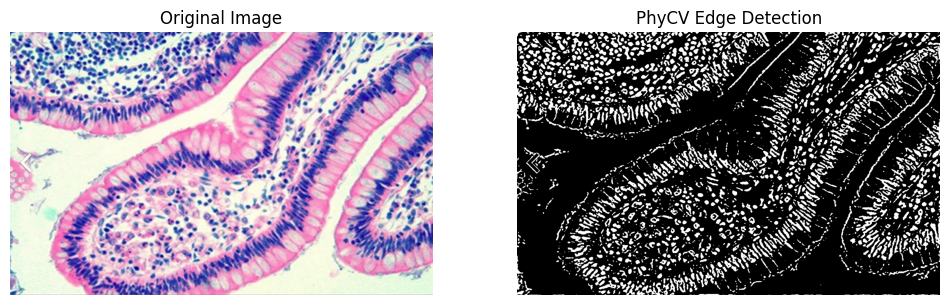

In [8]:
a = process_image("../input_images/cell.png","../pst_output",0.4,20,0.1,0.0,0.8,1)

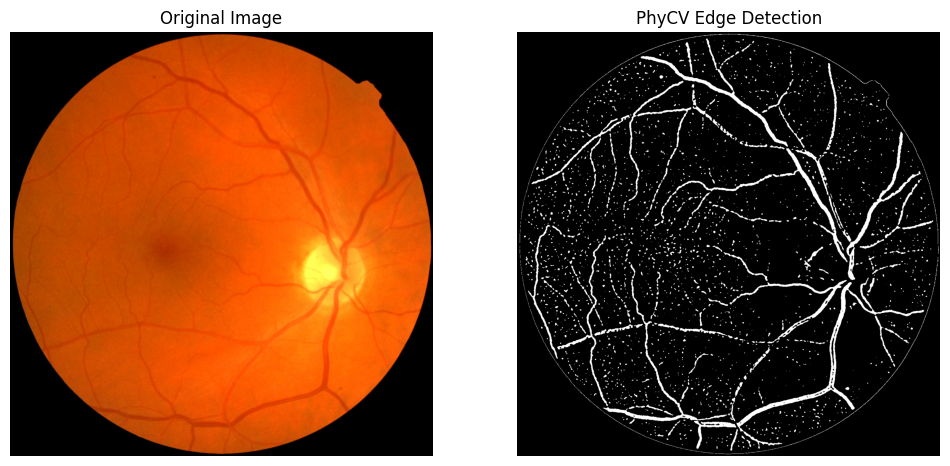

In [9]:
a = process_image("../input_images/retina.jpg","../pst_output",0.5,30,0.05,0.05,0.78,1)

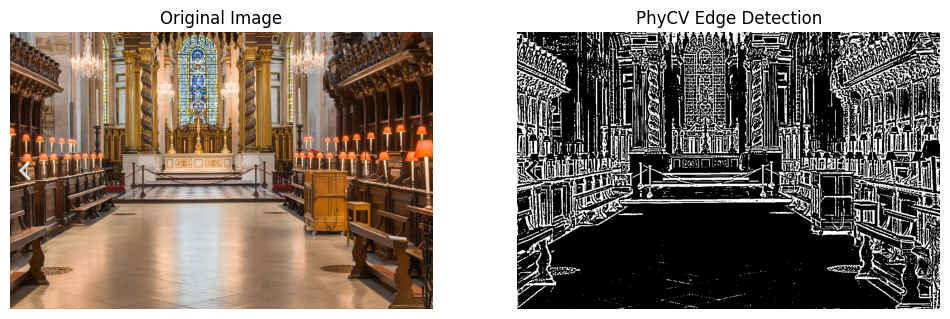

In [10]:
a = process_image("../input_images/palace.png","../pst_output",0.4,20,0.1,0.0,0.75,1)

## Step 2 - BDD100K Dataset

In [39]:
#Length of train and val sets
len([entry for entry in os.listdir("../bdd100k/labels/lane/masks/train/")]),len([entry for entry in os.listdir("../bdd100k/labels/lane/masks/val/")])

(70000, 10000)

In [9]:
#Write data to dataframe
with open('../bdd100k/labels/bdd100k_labels_images_train.json') as data_file:    
    data = json.load(data_file)  

In [10]:
df = pd.json_normalize(data)
df.head()

,name,timestamp,labels,attributes.weather,attributes.scene,attributes.timeofday
0,0000f77c-6257be58.jpg,10000,"[{'category': 'traffic light', 'attributes': {...",clear,city street,daytime
1,0000f77c-62c2a288.jpg,10000,"[{'category': 'traffic sign', 'attributes': {'...",clear,highway,dawn/dusk
2,0000f77c-cb820c98.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",clear,residential,dawn/dusk
3,0001542f-5ce3cf52.jpg,10000,"[{'category': 'traffic sign', 'attributes': {'...",clear,city street,night
4,0001542f-7c670be8.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",clear,highway,night


In [11]:
image_prefix = "../bdd100k/images/100k/train/"
annotation_prefix = "../bdd100k/labels/lane/masks/train/"

In [12]:
#Functions to show some example images with their ground truth lanes
def imshow_pair(image_pair, titles=('', ''), figsize=(10, 6),cmaps = ("viridis","gray")):
    fig, axes = plt.subplots(ncols=len(image_pair), figsize=figsize)
    for ax, img, label,cmap in zip_longest(axes.ravel(), image_pair, titles, cmaps,fillvalue=''):
        ax.imshow(img,cmap=cmap)
        ax.set_title(label)
def show_image(df,i):
    name = df["name"][i]
    name2 = df["name"][i][:-4]+".png"
    image = mpimg.imread(image_prefix+name)
    annotation = mpimg.imread(annotation_prefix+name2)
    #print(annotation)
    #annotation = annotation&8
    
    #annotation2 = (annotation == 15).astype(int)
    #print(collections.Counter(np.array(annotation2).flatten()),np.array(annotation2).shape)
    print("name:",name,", weather:",df["attributes.weather"][i],", scene:",df["attributes.scene"][i],", timeofday:",df["attributes.timeofday"][i])
    imshow_pair((image, annotation))


name: 0a4411cf-e30aa257.jpg , weather: partly cloudy , scene: highway , timeofday: daytime


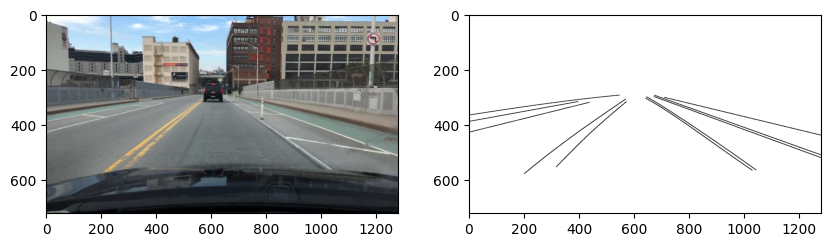

In [48]:
show_image(df,4000)

name: 0289eba3-3b2c545e.jpg , weather: foggy , scene: city street , timeofday: daytime


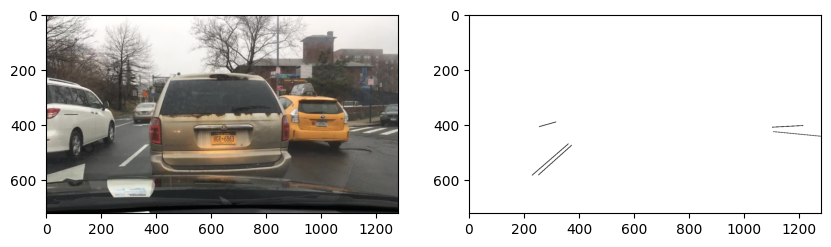

In [49]:
show_image(df,927)

name: 68d75887-5496076b.jpg , weather: rainy , scene: city street , timeofday: daytime


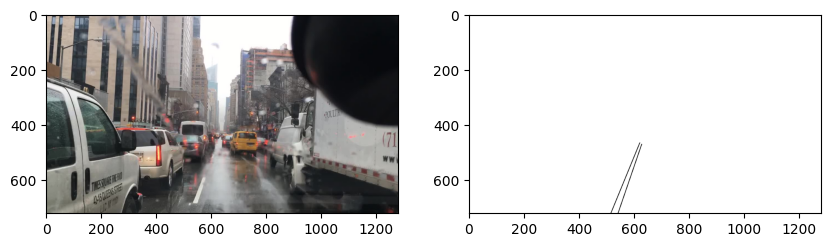

In [50]:
show_image(df,41000)

name: 99ac8fa4-c539ca27.jpg , weather: clear , scene: city street , timeofday: night


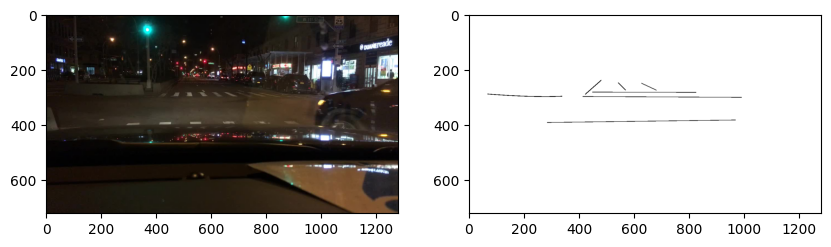

In [51]:
show_image(df,60000)

In [52]:
#Filtering dataframe by attributes
df[df["attributes.weather"]=="foggy"].head()

,name,timestamp,labels,attributes.weather,attributes.scene,attributes.timeofday
927,0289eba3-3b2c545e.jpg,10000,"[{'category': 'traffic sign', 'attributes': {'...",foggy,city street,daytime
1615,04488604-72f099d0.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",foggy,city street,night
2100,05ab62f4-613ed675.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",foggy,highway,daytime
2112,05b06a04-5d7141e0.jpg,10000,"[{'category': 'traffic light', 'attributes': {...",foggy,highway,daytime
3966,0a2804db-72d1407f.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",foggy,residential,daytime


In [13]:
#Dataloader for easy handling of data which stores everything in a dataframe for retrieval
class LaneDetectionDataset(Dataset):
    def __init__(self,df=None,mode="train"):
        if df:
            self.df = df
        else:
            with open('../bdd100k/labels/bdd100k_labels_images_'+mode+".json") as data_file:    
                data = json.load(data_file)
            self.df = pd.json_normalize(data)
            self.mode=mode
    def __getitem__(self,i):
        name = df["name"][i]
        name2 = df["name"][i][:-4]+".png"
        image = mpimg.imread(image_prefix+name)
        annotation = mpimg.imread(annotation_prefix+name2)
        annotation2 = (annotation == 15).astype(int)
        weather = df["attributes.weather"][i]
        scene=df["attributes.scene"][i]
        timeofday=df["attributes.timeofday"][i]
        return ((image,weather,scene,timeofday),annotation2)
    def __len__(self):
        return len(df)

In [18]:
train_data = LaneDetectionDataset(mode='train')
val_data = LaneDetectionDataset(mode='val')
train_data_loader = DataLoader(train_data, batch_size=4,shuffle=True, num_workers=0)
val_data_loader = DataLoader(val_data, batch_size=4,shuffle=True, num_workers=0)

## Step 3 - Inference on Pre-trained Model

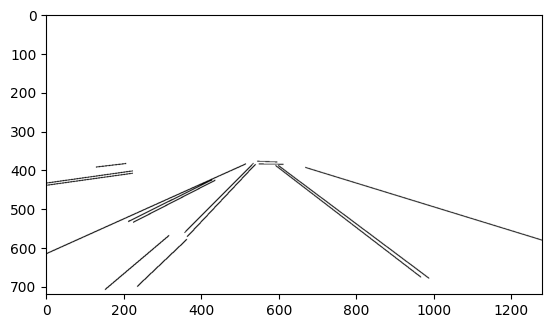

In [14]:
#Ground truth for image
annotation_prefix = "../bdd100k/labels/lane/masks/val/"
prefix2 = "../inference_yolop/val/"
name = "b1c66a42-6f7d68ca" #Choose which image to test
img = cv2.imread(annotation_prefix+name+".png")
plt.imshow(img,cmap="gray")

(720, 1280)


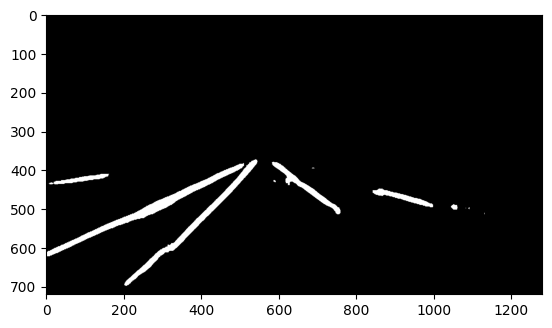

In [111]:
#YOLOP prediction for image
img = cv2.imread(prefix2+name+".jpg",cv2.IMREAD_UNCHANGED)
print(img.shape)
plt.imshow(img,cmap="gray")

In [67]:
val_json = "../bdd100k/labels/bdd100k_labels_images_val.json"
val_label_data = json.loads(open(val_json).read())

In [ ]:
#Attempt to combine lines in ground truth (in practice can just download combined lines data from prior works)
lines=[x for x in val_label_data[0]["labels"] if "category" in x and x["category"]=="lane"]
lines

36
5.824957676297414
38
47.02601962264741
40
13.13942619739937
42
309.68294924087604
44
8.053969747333241
46
6.992804999999976
48
670.8869056112078
50


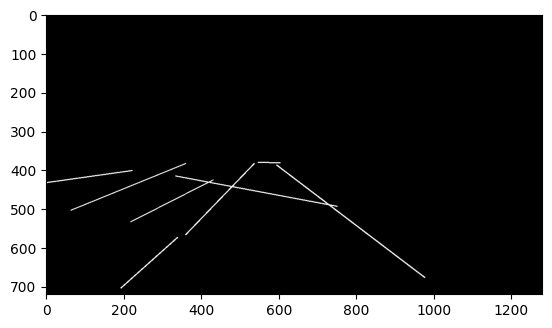

In [99]:
img = np.zeros((720,1280))
for i in range(0,len(lines),2):
    print(lines[i]["id"])
    start=np.array(lines[i]["poly2d"][0]["vertices"][0])
    end=np.array(lines[i]["poly2d"][0]["vertices"][1])
    if i+1!=len(lines):
        print(np.linalg.norm(start-lines[i+1]["poly2d"][0]["vertices"][0]))
        start = (start+lines[i+1]["poly2d"][0]["vertices"][0])/2
        end = (end+lines[i+1]["poly2d"][0]["vertices"][1])/2
    img = cv2.line(img,start.astype(int),end.astype(int),255,2)
plt.imshow(img,cmap="gray")

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


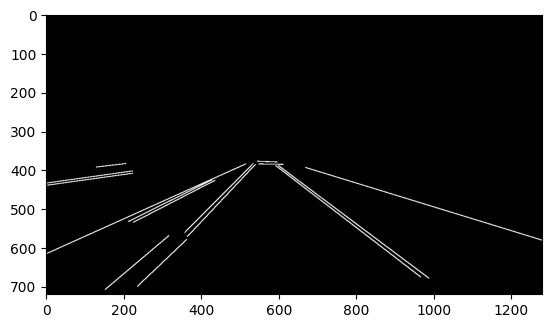

In [109]:
annotation_prefix = "../bdd100k/labels/lane/masks/val/"
prefix2 = "../inference_yolop/val/"
name = "b1c66a42-6f7d68ca"
img = cv2.imread(annotation_prefix+name+".png",cv2.IMREAD_UNCHANGED)
print(img)
plt.imshow(255-(img&8)*255/8,cmap="gray")

In [211]:
#Inference metrics (in practice can just use prior works' built-in test functions)
def pixel_accuracy(data):
    if data.mode=="train":
        x_folder="../bdd100k/labels/lane/masks/train/"
        y_folder="../inference_yolop/train/"
    else:
        x_folder="../bdd100k/labels/lane/masks/val/"
        y_folder="../inference_yolop/val/"
    total_accuracy = 0
    total_iou = 0
    num = 0
    names = list(data.df["name"])
    with tqdm.tqdm(range(0,len(names))) as pbar:
        for i in  pbar:
            name = names[i]
            png_name = name[:-4]+".png"
            x_path = x_folder+png_name
            y_path = y_folder+name
            x_img = cv2.imread(x_path,cv2.IMREAD_UNCHANGED)
            x_img = 255-((x_img&8)/8)*255
            y_img = cv2.imread(y_path,cv2.IMREAD_UNCHANGED)
            #y is predicted
            tp = np.sum((y_img==255)&(x_img==y_img))
            fn = np.sum((y_img==0)&(x_img!=y_img))
            fp = np.sum((y_img==255)&(x_img!=y_img))
            tn = np.sum((y_img==0)&(x_img==y_img))
            if(tp+fn+fp==0):
                iou=1
            else:
                iou = tp/(tp+fn+fp)
            total_iou+=iou
            #accuracy = np.sum(x_img==y_img)/x_img.size
            if(tp+fn==0):
                sen = 1
            else:
                sen = tp/(tp+fn)
            if(tn+fp==0):
                spe = 1
            else:
                spe = tn/(tn+fp)
            accuracy = (sen+spe)/2
            total_accuracy +=accuracy
            num+=1
            pbar.set_description("accuracy: "+str(total_accuracy/num)+", iou: "+str(total_iou/num))
            #return
    return total_accuracy/num,total_iou/num

In [212]:
#YOLOP inference metrics
pixel_accuracy(val_data)

accuracy: 0.7638485327584069, iou: 0.1786701687067896: 100%|██████████| 10000/10000 [01:39<00:00, 100.30it/s]


(0.7638485327584069, 0.1786701687067896)

In [412]:
pixel_accuracy(train_data)

accuracy: 0.7646653948360951, iou: 0.1808714001952803: 100%|██████████| 69863/69863 [10:50<00:00, 107.36it/s] 


(0.7646653948360951, 0.1808714001952803)

## Step 4 - PhyCV Preprocessing

In [21]:
#Convenient variables
path = "../bdd100k/images/100k/train/"
masks = "../bdd100k/labels/lane/masks/train/"
predict = "../inference_yolop/val/"
df = val_data.df


In [15]:
#Can choose slices of the dataframe to experiment with
hard_df = df[(df["attributes.timeofday"]=="daytime")].reset_index()
hard_df.head(100)

,index,name,timestamp,labels,attributes.weather,attributes.scene,attributes.timeofday
0,0,0000f77c-6257be58.jpg,10000,"[{'category': 'traffic light', 'attributes': {...",clear,city street,daytime
1,7,00054602-3bf57337.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",clear,city street,daytime
2,8,00067cfb-5443fe39.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",clear,city street,daytime
3,10,00067cfb-caba8a02.jpg,10000,"[{'category': 'traffic light', 'attributes': {...",clear,highway,daytime
4,12,00067cfb-f1b91e3c.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",clear,city street,daytime
...,...,...,...,...,...,...,...
95,172,007693e6-2535e7bf.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",clear,city street,daytime
96,173,007693e6-bc55f0e4.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",clear,city street,daytime
97,174,007693e6-c2a8b9a7.jpg,10000,"[{'category': 'car', 'attributes': {'occluded'...",undefined,city street,daytime
98,175,00779058-517a4591.jpg,10000,"[{'category': 'traffic light', 'attributes': {...",clear,city street,daytime


000e0252-8523a4a9.jpg


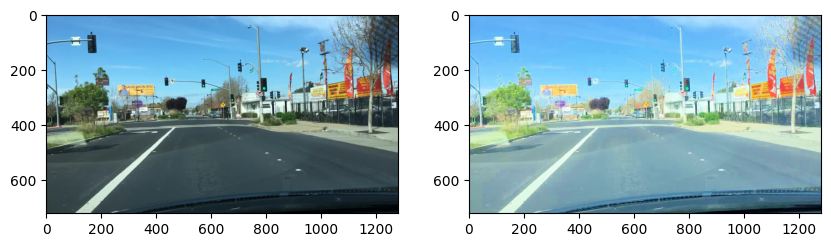

In [25]:
#Effect of VEVID enhancement
name = hard_df["name"][10]
print(name)
preimg = mpimg.imread(path+name)
vevid = VEVID()
vevid_img = vevid.run_lite(path+name, b = 0.2, G = 10)
imshow_pair((preimg,vevid_img),cmaps=("viridis","viridis"))
#cv2.imwrite("../vevid_test/test_img.jpg",vevid_img)
#Image.open(path+name)

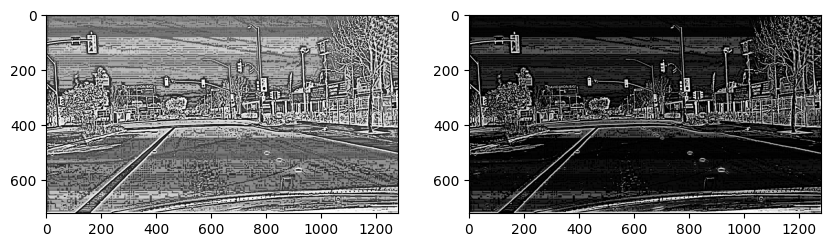

In [36]:
#Experiments run here on changing PST parameters and using digital vs analog settings
#Currently shows the effect of the x^5 function in the analog pipeline

#S, W=#kernel, sigma_LPF=noise reduction, thresh_min,thresh_max,morph_flag = convert image to binary if morph_flag is 1,
a = process_image(None,None,0.4,20,0.1,0.0,0.8,0,img=preimg,show=False)
tmp = np.array(a)
shape = tmp.shape
tmp2 = ((np.argsort(np.argsort(tmp.reshape((-1,))))+1)/tmp.size).reshape(shape)
c1=5
c2=5
c3=5
tmp3 = cv2.merge(((lambda x: x**c1)(tmp2),(lambda x: x**c2)(tmp2),(lambda x: x**c3)(tmp2)))

b = process_image(None,None,0.4,20,0.1,0.0,0.8,0,img=preimg,show=False)
#a = process_image(None,None,0.4,20,0.1,0.0,0.8,1,img=preimg,show=False)
imshow_pair((tmp2,tmp3),cmaps=("gray","gray"))


For self-contained final preprocesser see lanedetectionPreProcesser.ipynb